# Implementation of Hinton's Forward-Forward Algorithm on MNIST dataset using Fully Connected Layers

This notebook contains an implementation of Geoffrey Hinton's Forward-Forward Algorithm. Details about this algorithm can be found in Hinton's [paper](https://arxiv.org/abs/2212.13345#:~:text=The%20Forward%2DForward%20algorithm%20replaces,generated%20by%20the%20network%20itself).

Demonstrated below is 3.3. A simple supervised example of FF
## Preparation:

- **Import Libraries:** Set up the coding environment with the required libraries.

## Definition of Necessary Functions and Classes:

- **A. Function to Generate Negative Labels:** Generate negative samples for training.

- **B. Function to Overlay Label onto the Input Data:** Overlay the correct class onto the input data for positive forward pass.

- **C. Custom Net Class:** Definition of the network using the custom forward-forward approach.

- **D. Custom Layer Class:** Definition of a custom layer class to be used in the network.

- **E. Network Hyperparameters and Device Setup:** Set the hyperparameters for the network and configure the computation device.

## Implementation Steps:

- **1. Load Data:** Load the MNIST dataset for training and testing.

- **2. Create Network:** Instantiate the network architecture.

- **3. Train the Network:** Train the network using the forward-forward algorithm.

- **4. Test the Network:** Test the network's performance on the MNIST test set.


### Import Libraries

In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch 
import torch.nn as nn  
from torchvision.datasets import MNIST 
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda 
from torch.utils.data import DataLoader 
from torch.optim import Adam 

### A. Function to generate negative labels

In [2]:
# Generates negative labels for the training data, which are required for contrastive divergence training

def get_y_neg(y):

    # clone the original labels
    y_neg = y.clone()

    # loop through each sample in the labels
    for idx, y_samp in enumerate(y):
        
        # create a list of all possible class labels
        allowed_indices = list(range(10))

        # remove the correct label from the list, leaving only incorrect labels
        allowed_indices.remove(y_samp.item())

        # assigning a random label from allowed_indices to y_neg[idx].
        y_neg[idx] = torch.tensor(allowed_indices)[torch.randint(len(allowed_indices), size=(1,))].item()

    # return the labels with incorrect class, moved to the specified device (CPU or GPU)
    return y_neg.to(device)

### B. Function to overlay label onto the input data

In [3]:
# Overlays label info onto the input data, making a certain position in the tensor representative of the label

def overlay_y_on_x(x, y, classes=10):
    
    # Create a copy of the input tensor x
    x_ = x.clone()

    # for all samples, set the first 10 column values to 0
    x_[:, :classes] *= 0.0

    # For each sample, set the feature at index corresponding to the class y to be the max value in x
    x_[range(x.shape[0]), y] = x.max()

    # Return the transformed tensor
    return x_

### C. Custom Net Class

In [4]:
# Define a Net class that inherits from torch.nn.Module which is the base class for all neural network modules in PyTorch.
class Net(torch.nn.Module):

    # Initialize the Net class with dimensions of the neural network layers
    def __init__(self, dims):

        # Initialize the parent class torch.nn.Module, Net is the subclass and torch.nn.Module is the parent class
        super().__init__()

        # Initialize an empty layers list that will store the layers of the neural network
        self.layers = []

        # Create the layers of the neural network
        for d in range(len(dims) - 1):
            
            # Append a new layer to the layers list and move it to the appropriate device
            self.layers = self.layers + [Layer(dims[d], dims[d + 1]).to(device)]

    # Define a function to make predictions using the neural network
    def predict(self, x):

        # This list will store a measure of how much the input tensor x looks like each possible digit (from 0 to 9).
        goodness_per_label = []

        # For each possible label (0 to 9)
        for label in range(10):

            # Apply the label overlay to the input to make h tensor (50000, 784) of same size as x 
            h = overlay_y_on_x(x, label)

            '''
            h is 2D tensor of shape (10000, 784):

            h = 
                tensor([[0.0, 0.0, ......., 0.7],   # sample 1
                        [0.0, 0.0, ......., 0.6],   # sample 2
                        [0.0, 0.0, ......., 0.7],   # sample 3
                        [0.0, 1.0, ......., 0.7],   # sample 4
                        [0.0, 0.0, ......., 0.7],   # sample 5
                        ...
                        [0.0, 0.0, ......., 0.7],   # sample 9,996
                        [1.0, 0.0, ......., 0.7],   # sample 9,997
                        [0.0, 0.0, ......., 0.7],   # sample 9,998
                        [1.0, 0.0, ......., 0.7],   # sample 9,999
                        [0.0, 1.0, ......., 0.7]])  # sample 10,000          
                '''

            # Create a list to store the goodness of each layer for this label
            goodness = []

            # Pass the input through each Layer class element in layers list. 
            for layer in self.layers:
                
                # Apply the current layer to the transformed input tensor h, and then stores the result back into h.
                h = layer(h)

                # after layer 1, h size: (10000, 500)
                # after layer 2, h size: (10000, 500)

                # Add the squared mean (mean along each rows) of the output of this layer to the goodness list
                goodness = goodness + [h.pow(2).mean(1)]

                '''
                goodness_of_a_layer is 1D tensor of shape (50000,):

                goodness_layer1 = [
                    tensor([0.1, 0.2, ...................................., 0.1]),  # 10,000 mean squared activations for layer 1
                ]
                goodness_layer2 = [
                    tensor([0.1, 0.2, ...................................., 0.1]),  # 10,000 mean squared activations for layer 2
                ]
                '''
            
                '''
                goodness is a list of 1D tensors. list size is (50000,2):

                goodness = [
                    tensor([0.1, 0.2, ...................................., 0.1]),  # 10,000 mean squared activations for layer 1
                    tensor([0.3, 0.2, ...................................., 0.2])   # 10,000 mean squared activations for layer 2
                ]
                '''

            # Add the sum of the goodness of all layers for this label to the goodness_per_label list
            goodness_per_label += [sum(goodness).unsqueeze(1)]

            '''
            sum(goodness) is 1D tensor of shape (10000,):

            sum_of_goodness = tensor([0.4, 0.4, ...................................., 0.3]) # 10,000 sums of mean squared activations

            sum(goodness).unsqueeze(1) then adds an extra dimension to this tensor, 
            It is 2D tensor of shape (10000, 1):

            sum_of_goodness_unsqueezed = 
                tensor([[0.4], [0.4], ...................................., [0.3]])     
            '''
            
            '''
            This tensor is then added to the goodness_per_label list. For 10 lables, goodness_per_label might look something like this after 10 iterations:
            
            size of list is 10, each of 2D tensor shape (10000, 1):
            goodness_per_label = [
                tensor([[0.1], [0.5], ...................................., [0.6]]),   # sum of goodness for label 0
                tensor([[0.6], [0.6], ...................................., [0.7]]),   # sum of goodness for label 1
                tensor([[0.1], [0.6], ...................................., [0.7]]),   # sum of goodness for label 2
                tensor([[0.2], [0.6], ...................................., [0.7]]),   # sum of goodness for label 3
                tensor([[0.3], [0.6], ...................................., [0.7]]),   # sum of goodness for label 4
                tensor([[0.2], [0.6], ...................................., [0.7]]),   # sum of goodness for label 5
                tensor([[0.1], [0.6], ...................................., [0.7]]),   # sum of goodness for label 6
                tensor([[0.7], [0.6], ...................................., [0.7]]),   # sum of goodness for label 7
                tensor([[0.1], [0.6], ...................................., [0.7]]),   # sum of goodness for label 8
                tensor([[0.3], [0.6], ...................................., [0.7]])    # sum of goodness for label 9
            ]
            
            '''

        # Concatenate all the goodness_per_label tensors along dimension 1
        goodness_per_label = torch.cat(goodness_per_label, 1)

        '''
        tensor of shape (10000, 10):

        goodness_per_label = 
            tensor([[0.6, 0.7, ..., 0.7],   # goodness for sample 1
                    [0.5, 0.6, ..., 0.6],   # goodness for sample 2
                    [0.7, 0.6, ..., 0.7],   # goodness for sample 3
                    [0.7, 0.6, ..., 0.7],   # goodness for sample 4
                    [0.7, 0.6, ..., 0.7],   # goodness for sample 5
                    ...
                    [0.7, 0.6, ..., 0.7],   # goodness for sample 9,996
                    [0.7, 0.6, ..., 0.7],   # goodness for sample 9,997
                    [0.7, 0.6, ..., 0.7],   # goodness for sample 9,998
                    [0.7, 0.6, ..., 0.7],   # goodness for sample 9,999
                    [0.6, 0.7, ..., 0.7]])  # goodness for sample 10,000
                
        '''

        # Return the label with the highest goodness
        return goodness_per_label.argmax(1)
    
        '''
        return the indices of maximum values along dimension 1 (columns):
        1D tensor of shape (10000,):

        tensor([1, 9, ...................................., 1]) 
        '''

    # Define a function to train the neural network
    def train(self, x_pos, x_neg):

        # Initialize the positive and negative inputs
        h_pos, h_neg = x_pos, x_neg

        # For each layer in the neural network
        for i, layer in enumerate(self.layers):

            # Print which layer is currently being trained
            print("training layer: ", i)

            # Train the layer using the positive and negative inputs
            # layer.train() returns the positive and negative outputs of the layer which are 2d tensors of shape (50000, 500) for layer 1 and (50000, 500) for layer 2
            h_pos, h_neg = layer.train(h_pos, h_neg)

### D. Custom Layer Class

In [5]:
# Net is the main network and contains several instances of Layer, which represents individual layers of the network.
class Layer(nn.Linear):

    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):

        # Initialize the parent class, torch.nn.Linear
        super().__init__(in_features, out_features, bias, device, dtype)

        # Define a ReLU (Rectified Linear Unit) activation function
        self.relu = torch.nn.ReLU()

        # Define an Adam optimizer for this layer, with the learning rate defined by args.lr
        self.opt = Adam(self.parameters(), lr=args.lr)

        '''
        learning rate = 0.3
        '''

        # Define a threshold for the loss function, specified by args.threshold
        self.threshold = args.threshold

        '''
        3
        '''

        # Define the number of training epochs for this layer, specified by args.epochs
        self.num_epochs = args.epochs

        '''
        1000
        '''

    # Make each sample as unit magnitude then do A = X*W.T + B
    def forward(self, x):

        # Normalize the input tensor along each row
        # Each row in x_direction is a unit vector in the direction of the corresponding row in x
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)

        '''
        x_direction is 2D tensor of shape (50000, 784):

        x_direction = 
            tensor([[0.14, 0.25, ......., 0.09],   # sample 1
                    [0.32, 0.51, ......., 0.72],   # sample 2
                    [0.85, 0.17, ......., 0.37],   # sample 3
                    [0.92, 0.45, ......., 0.88],   # sample 4
                    [0.12, 0.93, ......., 0.76],   # sample 5
                    ...
                    [0.41, 0.18, ......., 0.14],   # sample 49,996
                    [0.36, 0.74, ......., 0.59],   # sample 49,997
                    [0.95, 0.21, ......., 0.86],   # sample 49,998
                    [0.73, 0.41, ......., 0.32],   # sample 49,999
                    [0.58, 0.66, ......., 0.09]])  # sample 50,000         
            '''
        
        # Compute the linear transformation followed by a ReLU activation
        # weight.T is 2D tensor of shape (784, 500)
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))
    
        '''
        weight is a 2D tensor of shape (500, 784):

        weight = 
            tensor([[0.14, 0.25, ......., 0.09],   # node 1
                    [0.32, 0.51, ......., 0.72],   # node 2
                    [0.85, 0.17, ......., 0.37],   # node 3
                    [0.92, 0.45, ......., 0.88],   # node 4
                    [0.12, 0.93, ......., 0.76],   # node 5
                    ...
                    [0.41, 0.18, ......., 0.14],   # node 496
                    [0.36, 0.74, ......., 0.59],   # node 497
                    [0.95, 0.21, ......., 0.86],   # node 498
                    [0.73, 0.41, ......., 0.32],   # node 499
                    [0.58, 0.66, ......., 0.09]])  # node 500

        bias is a 1D tensor of shape (500,):

        bias = tensor([0.1, 0.2, 0.3, ..., 0.498, 0.499, 0.500])

        bias.unsqueeze(0) is a 2D tensor of shape (1,500)

        bias_unsqueezed = tensor([[0.1, 0.2, 0.3, ..., 0.498, 0.499, 0.500]])
        '''

    # train a layer
    def train(self, x_pos, x_neg):
        
        # initialize lists to hold values
        loss_values = []
        g_pos_values = []
        g_neg_values = []

        # initialize figure
        fig = plt.figure(figsize=(12,8))

        # For each layer epoch 
        for i in range(self.num_epochs):

            # Compute the goodness for the positive and negative samples
            g_pos = self.forward(x_pos).pow(2).mean(1)

            '''
            g_pos is 1D tensor of shape (50000,):
            g_pos = tensor([0.7, 0.9, ...................................., 0.8])

            '''
            g_neg = self.forward(x_neg).pow(2).mean(1)

            '''
            g_neg is 1D tensor of shape (50000,):
            g_neg = tensor([0.1, 0.2, ...................................., 0.1])

            '''
            
            # Compute the loss using the computed goodness and the specified threshold
            loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()

            '''
            torch.cat([-g_pos + self.threshold, g_neg - self.threshold]) 
            is 1D tensor of shape (100000,)

            torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold])) 
            to ensure that all values are positive and to increase the difference between larger and smaller values
            is 1D tensor of shape (100000,)

            '1 + ...' adds 1 to each of these exponential scores. This ensures that even if all the scores are zero, the loss will not be negative.
            still a 1D tensor of shape (100000,)

            log()
            still a 1D tensor of shape (100000,)

            .mean() to take avg of all 100000 values
            loss is scalar

            '''

            # Zero the gradients
            self.opt.zero_grad()

            '''
            After self.opt.zero_grad() is called: The gradients of weights and biases are now zero

            weight is a 2D tensor of shape (500, 784) for layer 1 and (500,500) for layer 2:

            self.weight.grad = tensor([[0.00, 0.00, ...., 0.00],   # node 1
                                       [0.00, 0.00, ...., 0.00],   # node 2
                                       ...
                                       [0.00, 0.00, ...., 0.00],   # node 499
                                       [0.00, 0.00, ...., 0.00]])  # node 500

            bias is a 1D tensor of shape (500,) for layer 1 and (500,) for layer 2:

            self.bias.grad = tensor([0.00, 0.00, ..., 0.00, 0.00]) 
            
            '''

            # Compute the backward pass
            loss.backward()

            '''
            Assume the gradients of weights and biases after backpropagation are:

            weight is a 2D tensor of shape (500, 784) for layer 1 and (500,500) for layer 2:
            
            self.weight.grad = tensor([[0.01, 0.02, ...., 0.02],   # node 1
                                       [0.03, 0.01, ...., 0.01],   # node 2
                                       ...
                                       [0.01, 0.02, ...., 0.03],   # node 499
                                       [0.02, 0.01, ...., 0.01]])  # node 500

            bias is a 1D tensor of shape (500,) for layer 1 and (500,) for layer 2:

            self.bias.grad = tensor([0.01, 0.02, ..., 0.02, 0.01])  
            
            '''

            # Perform a step of optimization
            self.opt.step()

            '''
            After opt.step(): weight and bias has been updated

            weight is a 2D tensor of shape (500, 784) for layer 1 and (500, 500) for layer 2:
            weight = 
                tensor([[0.13, 0.26, ......., 0.08],   # node 1
                        [0.31, 0.52, ......., 0.73],   # node 2
                        [0.86, 0.16, ......., 0.38],   # node 3
                        [0.93, 0.44, ......., 0.89],   # node 4
                        [0.11, 0.94, ......., 0.75],   # node 5
                        ...
                        [0.42, 0.17, ......., 0.13],   # node 496
                        [0.35, 0.75, ......., 0.58],   # node 497
                        [0.96, 0.20, ......., 0.87],   # node 498
                        [0.74, 0.42, ......., 0.33],   # node 499
                        [0.59, 0.65, ......., 0.10]])  # node 500

            bias is a 1D tensor of shape (500,) for layer 1 and (500,) for layer 2:

            bias = 
                tensor([0.099, 0.201, 0.298, ..., 0.498, 0.501, 0.500])
            '''

            if i % args.log_interval == 0:
                loss_values.append(loss.item())
                g_pos_values.append(g_pos.mean().item())  # take mean of all batch values
                g_neg_values.append(g_neg.mean().item())  # take mean of all batch values

                # plotting
                plt.subplot(3,1,1)
                plt.plot(loss_values, color='blue')
                plt.title("Loss during training")

                plt.subplot(3,1,2)
                plt.plot(g_pos_values, color='green')
                plt.title("g_pos during training")

                plt.subplot(3,1,3)
                plt.plot(g_neg_values, color='red')
                plt.title("g_neg during training")

                plt.tight_layout()
                clear_output(wait=True)  # this clears the output of the cell, useful for updating the plots
                plt.show()

            # Print the loss at each step
            print(f'Loss at step {i}: {loss.item()}')

        # compute the output of the layer (A) for both positive and negative samples
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

### E. Network Hyperparameters and device setup

In [6]:
class Args:
    train_size = 50000
    test_size = 10000
    epochs = 1000
    lr = 0.05
    no_cuda = False
    no_mps = False
    save_model = False 
    threshold = 0
    seed = 1234
    log_interval = 10
    
args = Args()

use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

train_kwargs = {"batch_size": args.train_size} # dictionary specifying train batch size
test_kwargs = {"batch_size": args.test_size} # dictionary specifying test batch size

# If CUDA is available
if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

### 1. Load data

In [7]:
# 1) Converted to a tensor. MNIST are PIL images, so convert them to tensors to use with PyTorch
# 2) Normalized for the MNIST dataset
# 3) Flattened to a 1D tensor of 784 elements (28x28 pixels)
transform = Compose( 
    [
        ToTensor(),                                                                   
        Normalize((0.1307,), (0.3081,)),       
        Lambda(lambda x: torch.flatten(x)),    
    ]
)

# Create train and test DataLoader instances using the MNIST dataset
train_loader = DataLoader(MNIST("./data/", train=True, download=True, transform=transform), **train_kwargs) 
test_loader = DataLoader(MNIST("./data/", train=False, download=True, transform=transform), **test_kwargs) 

### 2. Create network

In [8]:
# Create an instance of Net class with an input dim of 784 neurons to match the flattened 28x28 pixel MNIST images
# and two intermediate dims of 500 each. 3 dims so we will have a 2 layer network.
net =  Net([784, 2000, 2000, 2000, 2000])

### 3. Train the network

In [9]:
# x is a 2D tensor of size (batch_size, 784) and y is a 1D tensor of size (batch_size,).
x, y = next(iter(train_loader))

# Move the input data and labels to the specified device (CPU or GPU).
x, y = x.to(device), y.to(device)

# overlay_y_on_x() function returns a 2D tensor of size (batch_size, 784)
x_pos = overlay_y_on_x(x, y)

# get_y_neg() function returns a 1D tensor of size (batch_size,) with the negative labels.
y_neg = get_y_neg(y)

# overlay_y_on_x() function returns a 2D tensor of size (batch_size, 784)
x_neg = overlay_y_on_x(x, y_neg)

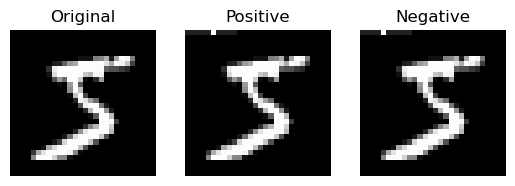

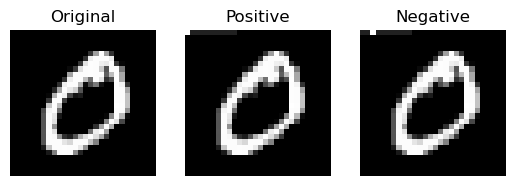

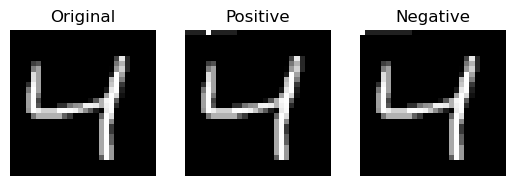

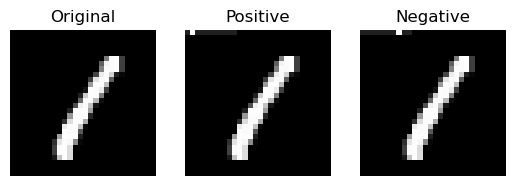

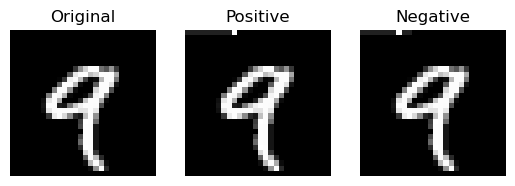

In [10]:
# Convert the tensors back to numpy arrays for plotting
x_np = x.cpu().numpy()
x_pos_np = x_pos.cpu().numpy()
x_neg_np = x_neg.cpu().numpy()

# Reshape the images from 784 to 28x28 if necessary
x_np = x_np.reshape(-1, 28, 28)
x_pos_np = x_pos_np.reshape(-1, 28, 28)
x_neg_np = x_neg_np.reshape(-1, 28, 28)

# Plot 5 samples
for i in range(5):
    fig, axs = plt.subplots(1, 3)
    
    # Original images
    axs[0].imshow(x_np[i], cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    # Positive images
    axs[1].imshow(x_pos_np[i], cmap='gray')
    axs[1].set_title('Positive')
    axs[1].axis('off')

    # Negative images
    axs[2].imshow(x_neg_np[i], cmap='gray')
    axs[2].set_title('Negative')
    axs[2].axis('off')

    plt.show()

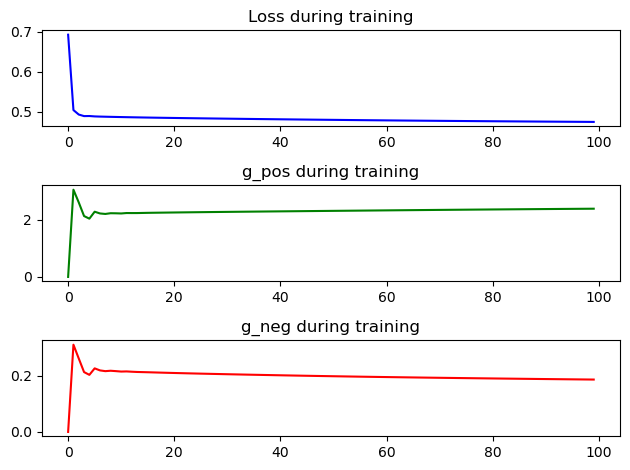

Loss at step 990: 0.4747256934642792
Loss at step 991: 0.47471755743026733
Loss at step 992: 0.4747093617916107
Loss at step 993: 0.4747011959552765
Loss at step 994: 0.47469303011894226
Loss at step 995: 0.4746849238872528
Loss at step 996: 0.47467678785324097
Loss at step 997: 0.47466862201690674
Loss at step 998: 0.4746604859828949
Loss at step 999: 0.47465240955352783


In [11]:
# Train the network with the positive and negative examples.
net.train(x_pos, x_neg)

In [12]:
# Predict the labels for the training data, compare them to the actual labels, and calculate the error rate.
#print("train error:", 1.0 - net.predict(x).eq(y).float().mean().item())
print("Train Accuracy: {:.2f}%".format(100 * net.predict(x).eq(y).float().mean().item()))

'''
net.predict(x) = tensor([0, 9, 7, ...., 8, 7, 4])

say Actual labels are y = tensor([0, 9, 1, ...., 8, 1, 5])])

net.predict(x).eq(y) = tensor([True, True, False, ...., True, False, False])

True becomes 1.0 and False becomes 0.0.
net.predict(x).eq(y).float() = tensor([1.0, 1.0, 0.0, ...., 1.0, 0.0, 0.0])

Take average of the tensor
net.predict(x).eq(y).float().mean() = tensor([0.6667])

Error rate = 1 - accuracy
1 - net.predict(x).eq(y).float().mean().item() = 1 - 0.6667 
'''

Train Accuracy: 93.29%


'\nnet.predict(x) = tensor([0, 9, 7, ...., 8, 7, 4])\n\nsay Actual labels are y = tensor([0, 9, 1, ...., 8, 1, 5])])\n\nnet.predict(x).eq(y) = tensor([True, True, False, ...., True, False, False])\n\nTrue becomes 1.0 and False becomes 0.0.\nnet.predict(x).eq(y).float() = tensor([1.0, 1.0, 0.0, ...., 1.0, 0.0, 0.0])\n\nTake average of the tensor\nnet.predict(x).eq(y).float().mean() = tensor([0.6667])\n\nError rate = 1 - accuracy\n1 - net.predict(x).eq(y).float().mean().item() = 1 - 0.6667 \n'

### 4. Test the Network

In [13]:
# Fetch one batch of the test data.
x_te, y_te = next(iter(test_loader))

# Move the test data and labels to the specified device (CPU or GPU).
x_te, y_te = x_te.to(device), y_te.to(device)

# If the 'save_model' argument is true, save the current state of the trained network.
if args.save_model:
    torch.save(net.state_dict(), "mnist_ff.pt")

# Predict the labels for the test data, compare them to the actual labels, and calculate the error rate.
#print("test error:", 1.0 - net.predict(x_te).eq(y_te).float().mean().item())
print("Test Accuracy: {:.2f}%".format(100 * net.predict(x_te).eq(y_te).float().mean().item()))

Test Accuracy: 93.18%
